# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.


Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
print(labels.info())
print(labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


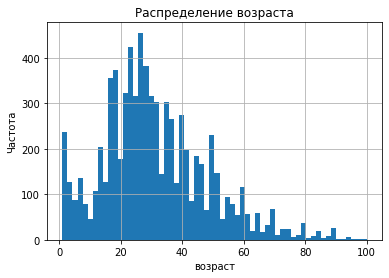

In [11]:
labels.hist(bins=60)
plt.title('Распределение возраста')
plt.xlabel('возраст')
plt.ylabel('Частота')
plt.show()

Распределение нормальное, большинство в возрасте от 15 до 35, но пару выбросов имеется.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
features_train, target_train = next(train_gen_flow)

Found 7591 validated image filenames.


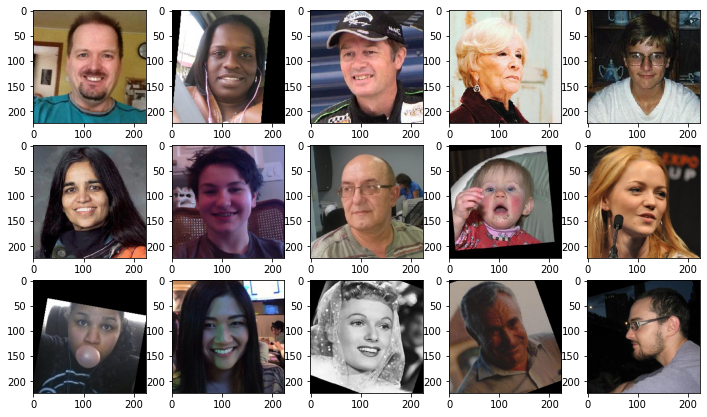

In [9]:
fig = plt.figure(figsize=(12,12))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(np.array(features_train[i])) 

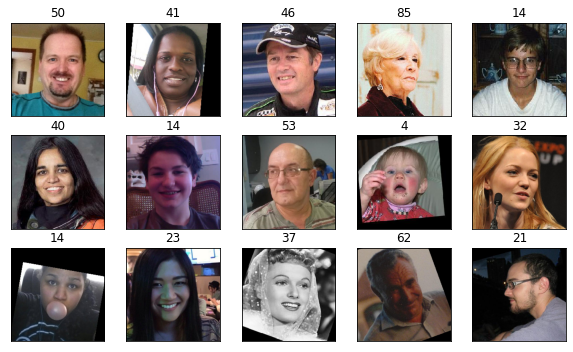

In [13]:
fig = plt.figure(figsize = (10,10))
for i in range(15):
    fig.add_subplot(5,5, i+1)
    plt.imshow(features_train[i])
    plt.title(target_train[i])
    plt.xticks([])
    plt.yticks([])


В датасете 7591 фотография, Некоторые фотографии неудачные так как на переднем плане мешаются лишние детали (например микрафон). Так же есть повернутые фотографии. Достаточно мало людей в возросте старше 75, в таких фотографиях машина может ошибится в предсказаниях. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)


```python
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return  train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        #horizontal_flip=True,
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return  test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr= 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:    
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 
```

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
  253952/94765736 [..............................] - ETA: 18s
 1294336/94765736 [..............................] - ETA: 7s 
 7135232/94765736 [=>............................] - ETA: 1s
 9969664/94765736 [==>...........................] - ETA: 1s
12697600/94765736 [===>..........................] - ETA: 1s
16932864/94765736 [====>.........................] - ETA: 1s
21159936/94765736 [=====>........................] - ETA: 1s
25387008/94765736 [=======>......................] - ETA: 1s
29622272/94765736 [========>.....................] - ETA: 1s
33857536/94765736 [=========>....................] - ETA: 1s
38092800/94765736 [===========>..................] - ETA: 1s
42319872/94765736 [============>.................] - ETA: 1s
46555136/94765736 [=============>................] - ETA: 1s
50790400/94765736 [===============>..............] - ETA: 0s
55025664/94765736 [================>.............] - ETA: 0s
59244544/94765736 [=================>............] - ETA: 0s
63479808/94765736 [===================>..........] - ETA: 0s
67715072/94765736 [====================>.........] - ETA: 0s
71958528/94765736 [=====================>........] - ETA: 0s
76193792/94765736 [=======================>......] - ETA: 0s
80412672/94765736 [========================>.....] - ETA: 0s
84647936/94765736 [=========================>....] - ETA: 0s
88875008/94765736 [===========================>..] - ETA: 0s
93118464/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 2s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-05-22 08:42:42.241618: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-22 08:42:44.545890: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 99s - loss: 223.6501 - mae: 10.7637 - val_loss: 487.9585 - val_mae: 16.7735
Epoch 2/10
356/356 - 56s - loss: 84.1455 - mae: 7.0158 - val_loss: 141.3483 - val_mae: 9.0337
Epoch 3/10
356/356 - 54s - loss: 58.1021 - mae: 5.7766 - val_loss: 115.8114 - val_mae: 8.2545
Epoch 4/10
356/356 - 39s - loss: 43.1163 - mae: 5.0362 - val_loss: 69.1280 - val_mae: 6.2652
Epoch 5/10
356/356 - 39s - loss: 32.9973 - mae: 4.3835 - val_loss: 109.3144 - val_mae: 8.4762
Epoch 6/10
356/356 - 39s - loss: 25.1787 - mae: 3.8245 - val_loss: 74.1639 - val_mae: 6.5586
Epoch 7/10
356/356 - 54s - loss: 20.2412 - mae: 3.4309 - val_loss: 66.6764 - val_mae: 6.1802
Epoch 8/10
356/356 - 56s - loss: 16.2291 - mae: 3.0606 - val_loss: 67.5278 - val_mae: 6.1605
Epoch 9/10
Epoch 10/10
356/356 - 57s - loss: 13.2203 - mae: 2.7762 - val_loss: 68.5397 - val_mae: 6.2207
356/356 - 55s - loss: 11.9540 - mae: 2.6560 - val_loss: 65.9447 - val_mae: 6.1756
WARNING:tensorflow:sample_weight modes were coerced from
  ...
  ['...']
    to  
119/119 - 10s - loss: 65.9447 - mae: 6.1756
Test MAE: 6.1756
```

После изменения input shape и отключения аугментации на тестовой выборки (horizontal_flip) значение MAE чуть повысилось до 6,1756. Количество эпох не меняла, осталось так 10. 

## Анализ обученной модели

В ходе проекта были проанализированы исходные данные и построена модель для определения возраста человека по фото. Итоговое значение MAE: 6,1756. Получается что модель ошибается примерно на 6 лет при предсказании возраста, как по мне это большая достаточно разница в возрасте, программа будет спутывать кассира при продаже алкоголя... например настощий возраст 15 а модель показывает 21, а значит алкоголь можно продать, но по факту нет. Так же предлагать товары, которые могут заинтересовать покупателей одной возрастной группы тоже достаточно спорно, ведь врятли подросток и уже взрослый человек пойдут в магазин покупать одинаковые товары, хотя если погрешность в 6 лет уже около 25-30 лет и больше то наверное разница не чувствительна. 

Но в общем можно сказать, что модель решает задачу поставленную заказчиком. Но стоит улучшить модель, для этого добавить фотографий и убрать те на которых передний план это не человек, или кривую фотографию. 


## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы